# Sudoku

### Problem parameters definition

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

Q = np.array([
    [0, 0, 2,   0, 0, 9,   0, 5, 0],
    [0, 3, 0,   2, 0, 0,   1, 0, 0],
    [0, 0, 7,   0, 0, 5,   3, 0, 0],
    
    [7, 8, 0,   0, 0, 0,   0, 0, 0],
    [9, 0, 0,   0, 0, 0,   2, 6, 0],
    [0, 0, 0,   0, 9, 3,   0, 0, 5],
    
    [0, 0, 6,   0, 0, 0,   0, 9, 0],
    [0, 2, 1,   0, 0, 4,   5, 0, 3],
    [0, 0, 0,   7, 0, 0,   0, 0, 1],
])

### Definition utilities functions

In [2]:
# Utilities function used to make our data compatible with cvxpy
def flattened_square_indices(i, j, size = 3, square_shape = 9):
    
    # Calculate the slice bounds for the square
    i_min, i_max = max(0, i + 1 - size // 2), min(square_shape, i+1 + size // 2 + 1)
    j_min, j_max = max(0, j + 1 - size // 2), min(square_shape, j+1 + size // 2 + 1)

    indices = []

    for i in range(i_min, i_max):
        for j in range(j_min, j_max):
            indices.append((square_shape*i + j))

    return indices

In [3]:
def sudoku_contraints(b):
    # Define the constraints for a sudoku board
    constraints = []

    # Each cell contains exactly one number
    for i in range(9):
        for j in range(9):
            constraints.append(cp.sum(b[i*9 + j, :]) == 1)

    # Each row contains each number exactly once
    for i in range(9):
        for k in range(9):
            horizontal_index = np.ravel_multi_index((i, np.arange(9)), (9,9))
            constraints.append(cp.sum(b[horizontal_index, k]) == 1)

    # Each column contains each number exactly once
    for j in range(9):
        for k in range(9):
            vertical_index = np.ravel_multi_index((np.arange(9), j), (9,9))
            constraints.append(cp.sum(b[vertical_index, k]) == 1)

    # Each 3x3 subgrid contains each number exactly once
    for i in range(3):
        for j in range(3):
            for k in range(9):
                square_index = flattened_square_indices(i*3, j*3, 3)
                constraints.append(cp.sum(b[square_index, k]) == 1)

    # Fix the known numbers
    for i in range(9):
        for j in range(9):
            if Q[i, j] != 0:
                constraints.append(b[i*9 + j, int(Q[i, j]-1)] == 1)
    
    return constraints

### Optimization problem definition

In [4]:
# Define the binary decision variables on a flattened sudoku board
b = cp.Variable((9*9, 9), boolean=True)

# Define the constraints
constraints = sudoku_contraints(b)

# Define the objective
obj = cp.Minimize(0)

# Define the problem
prob = cp.Problem(obj, constraints)

# Solve the problem
prob.solve()

print(f'Status: {prob.status}')

Status: optimal


### Problem solution

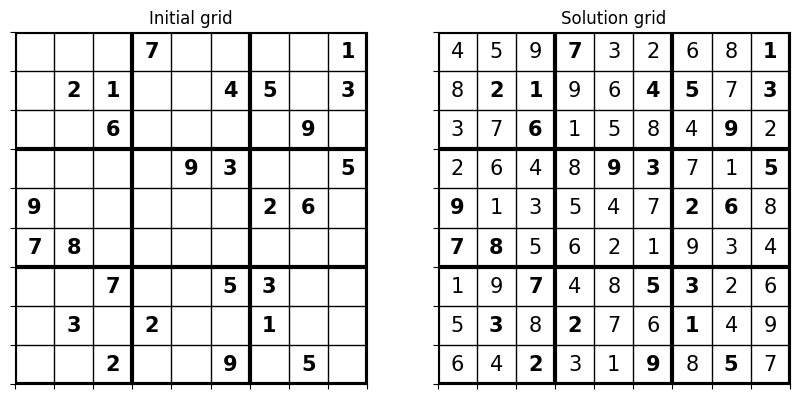

In [18]:
def plot_sudoku_grid(initial_grid, solution_grid):
    # Function to plot the sudoku grid
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(10,10))
    axes = []
    axes.append({'matplotlib': ax0,'grid': initial_grid,'title': 'Initial grid'})
    axes.append({'matplotlib': ax1,'grid': solution_grid, 'title': 'Solution grid'})
    
    for ax in axes:  
        # Add gridlines
        ax['matplotlib'].set_xticks(np.arange(-0.5, 9.5, 1))
        ax['matplotlib'].set_yticks(np.arange(-0.5, 9.5, 1))
        ax['matplotlib'].set_xticklabels([])
        ax['matplotlib'].set_yticklabels([])
        ax['matplotlib'].grid(color='black', linewidth=1)
        ax['matplotlib'].set_title(ax['title'])
        bold_indeces = [-0.5, 2.5, 5.5, 8.5]
        for i in bold_indeces:
            ax['matplotlib'].axhline(y=i, color='black', linewidth=3, linestyle='-')
            ax['matplotlib'].axvline(x=i, color='black', linewidth=3, linestyle='-')
        for i in range(9):
            for j in range(9):
                if ax['grid'][i, j] != 0:
                    if ax['grid'][i, j] == initial_grid[i, j]:
                        ax['matplotlib'].text(j, i, str(int(ax['grid'][i, j])), fontsize=15, va='center', ha='center', weight='bold')
                    else:
                        ax['matplotlib'].text(j, i, str(int(ax['grid'][i, j])), fontsize=15, va='center', ha='center')
        ax['matplotlib'].set_aspect('equal')
    plt.show()

Qf = np.zeros((9,9))
for i in range(9):
    for j in range(9):
        for k in range(9):
            if b[i*9 + j, k].value == 1:
                Qf[i,j] = k+1

plot_sudoku_grid(Q, Qf)
